In [1]:
# Import libraries and dependencies
import os
import pandas as pd
from pathlib import Path
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
%matplotlib inline

In [2]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version = "v2"
)

In [4]:
def days_to_trading_days(days):
    return round(days * 252 / 365)

def trading_days_to_days(trading_days):
    return round(trading_days * 365 / 252)

In [5]:
def get_barset_amzn(start_date, end_date):
    """
    Gets alpaca barset for AMZN with 1D timeframe for the given dates
    and returns the data in a pandas dataframe.
    
    If the num of days is greater than 1000, it makes more than one api
    call and combines the responses in a single dataframe.
    """
    # Initialize a variable `df` to store the final dataframe.
    df = None;
    
    # Calculate the num of days in the given start and end dates
    days = (end_date - start_date).days
    
    # Convert num of days into num of trading days
    trading_days = days_to_trading_days(days)
    
    # Calculate the num of calls to make
    # e.g. for 1500 trading days we need to make at least 2 api calls
    # trading_days = 1500, round(trading_days/1000) = 1, num_api_calls = 1 + 1 = 2
    num_api_calls = 1 + round(trading_days/1000)
    
    # 252 trading days = 365 normal days
    # 1000 trading days = 1000 * 365 / 252 normal days
    days_per_1k_trading_days = trading_days_to_days(1000)
    
    start = start_date 
    for i in range(num_api_calls):
        end = start + pd.DateOffset(days_per_1k_trading_days)
        print(str(start)+" to "+str(end))
        tmp_df = api.get_barset(
            "AMZN",
            "1D",
            start = start.isoformat(),
            end = end.isoformat() ,
            limit = 1000
        ).df
        start = end       
        if df is None:
            df = tmp_df
        else:
            df = pd.concat([df, tmp_df])
                   
    return df

In [6]:
start_date = pd.Timestamp("2012-01-01", tz="America/New_York")
end_date = pd.Timestamp("2021-04-08", tz="America/New_York")
df = get_barset_amzn(start_date, end_date)

2012-01-01 00:00:00-05:00 to 2015-12-19 00:00:00-05:00
2015-12-19 00:00:00-05:00 to 2019-12-06 00:00:00-05:00
2019-12-06 00:00:00-05:00 to 2023-11-23 00:00:00-05:00


In [7]:
(end_date - start_date).days

3384

In [8]:
df.shape[0]

2332

In [9]:
df

AMZN                                        
                                open       high        low    close   volume
time                                                                        
2012-01-03 00:00:00-05:00   176.0966   179.4750   175.3474   179.03  4784291
2012-01-04 00:00:00-05:00   179.2100   180.5000   176.0650   177.50  4011935
2012-01-05 00:00:00-05:00   175.9400   178.2500   174.0500   177.63  3459141
2012-01-06 00:00:00-05:00   178.0700   184.6500   177.5000   182.67  6588487
2012-01-09 00:00:00-05:00   182.7600   184.3700   177.0000   178.57  4564491
...                              ...        ...        ...      ...      ...
2021-04-01 00:00:00-04:00  3116.3500  3162.4400  3115.5500  3161.55  2642215
2021-04-05 00:00:00-04:00  3173.5000  3235.9550  3161.2400  3225.26  2813107
2021-04-06 00:00:00-04:00  3223.7500  3247.3100  3217.0400  3223.99  2095298
2021-04-07 00:00:00-04:00  3230.3800  3303.6125  3223.6500  3279.39  3070221
2021-04-08 00:00:00-04:00  3309.1400  3324.5000  3292.0000  3299.99  2543206

[2332 rows x 5 columns]

In [10]:
# Configure a Monte Carlo simulation to forecast ten years cumulative returns
MC_AMZN = MCSimulation(
    portfolio_data = df,
    weights = [1],
    num_simulation = 500,
    num_trading_days = 252*10
)

In [11]:
# Printing the simulation input data
MC_AMZN.portfolio_data

AMZN                                          \
                                open       high        low    close   volume   
time                                                                           
2012-01-03 00:00:00-05:00   176.0966   179.4750   175.3474   179.03  4784291   
2012-01-04 00:00:00-05:00   179.2100   180.5000   176.0650   177.50  4011935   
2012-01-05 00:00:00-05:00   175.9400   178.2500   174.0500   177.63  3459141   
2012-01-06 00:00:00-05:00   178.0700   184.6500   177.5000   182.67  6588487   
2012-01-09 00:00:00-05:00   182.7600   184.3700   177.0000   178.57  4564491   
...                              ...        ...        ...      ...      ...   
2021-04-01 00:00:00-04:00  3116.3500  3162.4400  3115.5500  3161.55  2642215   
2021-04-05 00:00:00-04:00  3173.5000  3235.9550  3161.2400  3225.26  2813107   
2021-04-06 00:00:00-04:00  3223.7500  3247.3100  3217.0400  3223.99  2095298   
2021-04-07 00:00:00-04:00  3230.3800  3303.6125  3223.6500  3279.39  3070221   
2021-04-08 00:00:00-04:00  3309.1400  3324.5000  3292.0000  3299.99  2543206   

                                        
                          daily_return  
time                                    
2012-01-03 00:00:00-05:00          NaN  
2012-01-04 00:00:00-05:00    -0.008546  
2012-01-05 00:00:00-05:00     0.000732  
2012-01-06 00:00:00-05:00     0.028374  
2012-01-09 00:00:00-05:00    -0.022445  
...                                ...  
2021-04-01 00:00:00-04:00     0.021288  
2021-04-05 00:00:00-04:00     0.020152  
2021-04-06 00:00:00-04:00    -0.000394  
2021-04-07 00:00:00-04:00     0.017184  
2021-04-08 00:00:00-04:00     0.006282  

[2334 rows x 6 columns]

In [12]:
# Run Monte Carlo simulations to forecast one year daily returns
MC_AMZN.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.984853,1.000368,1.024457,1.007099,0.981138,0.977036,0.991263,1.030398,0.997948,1.023046,...,0.994474,0.997101,0.998921,0.989032,1.013164,1.012177,0.978040,1.032595,0.983848,0.974104
2,0.999655,0.990456,1.044712,1.016692,0.960988,0.975634,0.982965,1.009143,0.993741,1.003613,...,0.975974,1.030577,1.003360,0.978929,1.002111,0.990147,1.007901,1.019223,0.954577,0.965711
3,1.014969,0.970477,1.024672,1.012737,0.954145,0.979133,0.995219,1.025932,0.964832,0.994958,...,0.998663,1.017105,0.996297,0.973146,1.025598,1.008587,0.990787,1.041212,0.996887,0.957467
4,1.053319,0.957273,1.030183,1.024439,0.969974,1.006131,0.943770,1.007439,0.945538,0.970508,...,1.024399,0.999439,0.961159,0.983690,1.023712,0.991733,0.949573,1.060649,0.957036,0.941038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,7.337116,12.491501,23.597661,5.878399,148.200415,9.878982,1.829605,85.554509,52.594198,39.951474,...,114.090630,10.789054,28.064792,2.208221,15.639613,70.274023,9.370734,13.368724,36.058189,94.139787
2517,7.301555,12.658009,24.415417,5.811690,153.720345,10.055577,1.838587,85.121444,52.091188,39.789990,...,113.215049,10.425295,27.402460,2.227108,15.908339,71.187193,9.187051,13.509357,35.667979,92.732710
2518,7.229413,12.773202,25.001629,5.877480,157.775715,10.066801,1.791679,83.821418,51.419405,39.715593,...,114.394256,10.256338,26.821235,2.241616,16.063969,71.373073,9.021094,13.568878,35.831777,88.910526
2519,7.154676,13.279577,24.927073,5.939648,162.674859,10.157841,1.778117,83.017126,52.175227,38.695516,...,114.914228,10.403404,26.629414,2.316422,16.558979,70.783689,9.328404,14.008430,36.265556,85.706380


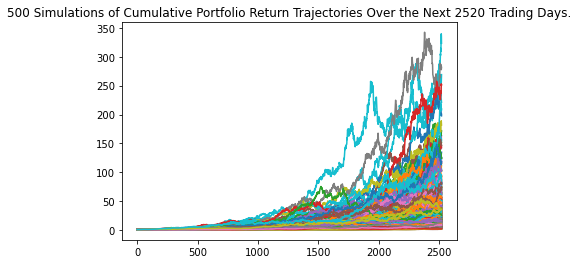

In [13]:
# Plot simulation outcomes
line_plot = MC_AMZN.plot_simulation()

# Save the plot for future usage
line_plot.get_figure().savefig("MC_tenyear_sim_plot.png", bbox_inches="tight")

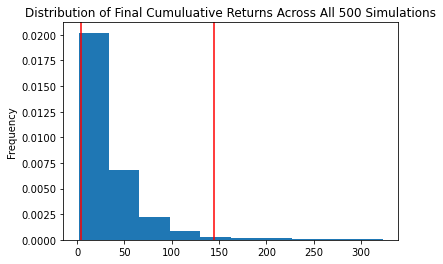

In [14]:
# Plot probability distribution and confidence intervals
dist_plot = MC_AMZN.plot_distribution()

# Save the plot for future usage
dist_plot.get_figure().savefig('MC_tenyear_dist_plot.png',bbox_inches='tight')

In [15]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl = MC_AMZN.summarize_cumulative_return()

# Print summary statistics
print(tbl)

count           500.000000
mean             35.344503
std              39.889427
min               1.556582
25%              10.749677
50%              23.228748
75%              43.430116
max             323.213768
95% CI Lower      3.687712
95% CI Upper    144.514258
Name: 2520, dtype: float64


In [16]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $15,000 investments in AMZN stocks
ci_lower = round(tbl[8]*10000,2)
ci_upper = round(tbl[9]*10000,2)

# Print results
print(f"There is a 95% chance that an initial investment of $15,000 in the portfolio"
      f" over the next year will end within in the range of"
      f" ${ci_lower} and ${ci_upper}.")

There is a 95% chance that an initial investment of $15,000 in the portfolio over the next year will end within in the range of $36877.12 and $1445142.58.


In [17]:
# Compute summary statistics from the simulated daily returns
simulated_returns_data = {
    'mean' : list(MC_AMZN.simulated_return.mean(axis=1)),
    'median' : list(MC_AMZN.simulated_return.median(axis=1)),
    'min' : list(MC_AMZN.simulated_return.min(axis=1)),
    'max' : list(MC_AMZN.simulated_return.max(axis=1))
}

# Create a DataFrame with the summary statistics
df_simulated_returns = pd.DataFrame(simulated_returns_data)

# Display sample data
df_simulated_returns.head()

,mean,median,min,max
0,1.000000,1.000000,1.000000,1.000000
1,1.001844,1.001534,0.949707,1.061628
2,1.003252,1.003240,0.909299,1.080549
3,1.005432,1.004973,0.893589,1.089159
4,1.008285,1.008466,0.884028,1.106382


<AxesSubplot:title={'center':'Simulated Daily Returns Behavior of AMZN Stock Over the Next Year'}>

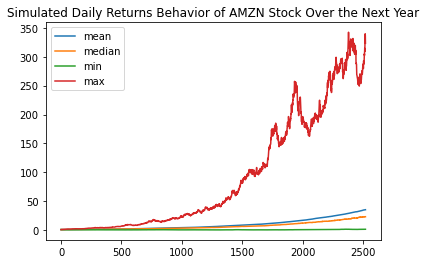

In [18]:
# Use the `plot` function to visually analyze the trajectory of AMZN stock daily returns on a trading day simulation
df_simulated_returns.plot(title="Simulated Daily Returns Behavior of AMZN Stock Over the Next Year")

In [19]:
# Set initial investment
initial_investment = 15000

# Multiply an initial investment by the daily returns of simulative stock prices to return the progression of daily returns in terms of money
cumulative_pnl = initial_investment * df_simulated_returns

# Display sample data
cumulative_pnl.head()

,mean,median,min,max
0,15000.000000,15000.000000,15000.000000,15000.000000
1,15027.664733,15023.003266,14245.606311,15924.414163
2,15048.772796,15048.593136,13639.483370,16208.238829
3,15081.476343,15074.595879,13403.827537,16337.387400
4,15124.278791,15126.986012,13260.417651,16595.730494


<AxesSubplot:title={'center':'Simulated Outcomes Behavior of AMZN Stock Over the Next Year'}>

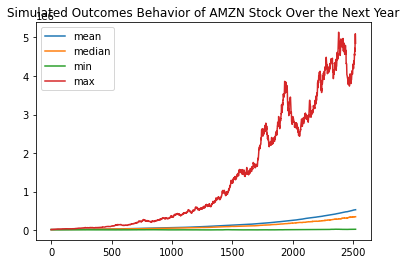

In [20]:
# Use the 'plot' function to create a chart of the simulated profits/losses
cumulative_pnl.plot(title="Simulated Outcomes Behavior of AMZN Stock Over the Next Year")